In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Rescaling
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# **Downloading data**

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"deenagautam","key":"f34672e879d3a53eb7e39f94a8064d30"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # ensure the file has the correct permissions

In [ ]:
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

Dataset URL: https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset
License(s): copyright-authors
100% 3.58G/3.58G [03:26<00:00, 17.6MB/s]
100% 3.58G/3.58G [03:26<00:00, 18.6MB/s]


In [ ]:
!unzip real-life-violence-situations-dataset.zip

Archive:  real-life-violence-situations-dataset.zip
  inflating: Real Life Violence Dataset/NonViolence/NV_1.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_10.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_100.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_1000.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_101.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_102.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_103.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_104.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_105.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_106.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_107.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_108.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_109.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_11.mp4  
  inflating: Real Life Violence Dataset/N

# **Preprocessing**

In [ ]:
# Function to extract frames from video
def extract_frames(video_path, target_height, target_width, num_frames):
    frames = []
    # creating an object which allows access to the video frames
    cap = cv2.VideoCapture(video_path)
     # getting frame count for a video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # creating a list of length = num of frames
    frame_indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)

    # iterating over each index in frame_indices
    for idx in frame_indices:
        # setting the frame position to the current index
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        # reading the frame at the current position
        ret, frame = cap.read()
        if ret:
            # resizing each frame to 160 x 160
            frame = cv2.resize(frame, (target_width, target_height))
            # converting each frame to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

    cap.release()
    return frames

# Function to preprocess fight videos
def preprocess_real_life_fi_data(data_dir, target_height, target_width, num_frames):
    X = []
    y = []

    label=1
    count_file = 0

    for video_name in os.listdir(data_dir):
        count_file+=1
        print(count_file)
        # collecting 800 out of 1000 videos
        if count_file>800:
          break
        video_path = os.path.join(data_dir, video_name)
        print(video_path)
         # fetching preprocessed frames
        frames = extract_frames(video_path, target_height, target_width, num_frames)
        if len(frames) == num_frames:
            X.append(frames)
            y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

# Function to preprocess no-fight videos
def preprocess_real_life_no_data(data_dir, target_height, target_width, num_frames):
    X = []
    y = []

    count_file = 0
    label=0

    for video_name in os.listdir(data_dir):
        count_file+=1
        print(count_file)
        # collecting 800 out of 1000 videos
        if count_file>800:
          break
        video_path = os.path.join(data_dir, video_name)
        print(video_path)
         # fetching preprocessed frames
        frames = extract_frames(video_path, target_height, target_width, num_frames)
        if len(frames) == num_frames:
            X.append(frames)
            y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [ ]:
# Parameters
target_height = 160
target_width = 160
num_frames = 16
batch_size = 32
epochs = 25

In [ ]:
# Preprocess no-fight videos
data_dir_real_life_no = '/content/Real Life Violence Dataset/NonViolence'
X_rl_no, y_rl_no = preprocess_real_life_no_data(data_dir_real_life_no, target_height, target_width, num_frames)

1
/content/Real Life Violence Dataset/NonViolence/NV_160.mp4
2
/content/Real Life Violence Dataset/NonViolence/NV_714.mp4
3
/content/Real Life Violence Dataset/NonViolence/NV_966.mp4
4
/content/Real Life Violence Dataset/NonViolence/NV_8.mp4
5
/content/Real Life Violence Dataset/NonViolence/NV_169.mp4
6
/content/Real Life Violence Dataset/NonViolence/NV_362.mp4
7
/content/Real Life Violence Dataset/NonViolence/NV_311.mp4
8
/content/Real Life Violence Dataset/NonViolence/NV_908.avi
9
/content/Real Life Violence Dataset/NonViolence/NV_979.mp4
10
/content/Real Life Violence Dataset/NonViolence/NV_333.mp4
11
/content/Real Life Violence Dataset/NonViolence/NV_706.mp4
12
/content/Real Life Violence Dataset/NonViolence/NV_726.mp4
13
/content/Real Life Violence Dataset/NonViolence/NV_896.avi
14
/content/Real Life Violence Dataset/NonViolence/NV_269.mp4
15
/content/Real Life Violence Dataset/NonViolence/NV_637.mp4
16
/content/Real Life Violence Dataset/NonViolence/NV_62.mp4
17
/content/Real Lif

In [ ]:
# Preprocess fight videos
data_dir_real_life_fi = '/content/Real Life Violence Dataset/Violence'
X_rl_fi, y_rl_fi = preprocess_real_life_fi_data(data_dir_real_life_fi, target_height, target_width, num_frames)

1
/content/Real Life Violence Dataset/Violence/V_818.mp4
2
/content/Real Life Violence Dataset/Violence/V_731.mp4
3
/content/Real Life Violence Dataset/Violence/V_431.mp4
4
/content/Real Life Violence Dataset/Violence/V_98.mp4
5
/content/Real Life Violence Dataset/Violence/V_102.mp4
6
/content/Real Life Violence Dataset/Violence/V_880.mp4
7
/content/Real Life Violence Dataset/Violence/V_397.mp4
8
/content/Real Life Violence Dataset/Violence/V_710.mp4
9
/content/Real Life Violence Dataset/Violence/V_418.mp4
10
/content/Real Life Violence Dataset/Violence/V_904.mp4
11
/content/Real Life Violence Dataset/Violence/V_914.mp4
12
/content/Real Life Violence Dataset/Violence/V_353.mp4
13
/content/Real Life Violence Dataset/Violence/V_118.mp4
14
/content/Real Life Violence Dataset/Violence/V_215.mp4
15
/content/Real Life Violence Dataset/Violence/V_825.mp4
16
/content/Real Life Violence Dataset/Violence/V_296.mp4
17
/content/Real Life Violence Dataset/Violence/V_372.mp4
18
/content/Real Life Vi

In [ ]:
X_rl_fi.shape

(799, 16, 160, 160, 3)

In [ ]:
# concatinating all feature columns from fight and no-fight
X=np.concatenate((X_rl_fi,X_rl_no),axis=0)
# concatinating labels from fight and no-fight
y=np.concatenate((y_rl_fi,y_rl_no),axis=0)

# **Shuffling and Splitting**

In [ ]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

In [ ]:
x_shuffled = X[indices]
y_shuffled = y[indices]

In [ ]:
x_shuffled.shape

(1596, 16, 160, 160, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_shuffled, y_shuffled, test_size=0.2, random_state=42, stratify=y_shuffled)

In [ ]:
print(f"X_train -> {X_train.shape}")
print(f"y_train -> {y_train.shape}")
print(f"X_test -> {X_test.shape}")
print(f"y_test -> {y_test.shape}")

X_train -> (1276, 16, 160, 160, 3)
y_train -> (1276,)
X_test -> (320, 16, 160, 160, 3)
y_test -> (320,)


- 1276 videos of 16 frames where each frame is sized 160 X 160 X 3 channels in RGB format, used for training

# **Creating model**

In [ ]:
def VD_model(tf,wghts):

    layers = tf.keras.layers
    models = tf.keras.models
    num_classes = 2

    # Load the VGG19 model
    base_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(160, 160, 3))

    # Freeze all layers initially
    base_model.trainable = False


    # CNN for feature extraction
    cnn = models.Sequential()
    cnn.add(base_model)
    cnn.add(layers.Flatten())

    # final sequential model for video classification
    model = models.Sequential()
    model.add(layers.TimeDistributed(cnn, input_shape=(num_frames, target_height, target_width, 3)))
    model.add(layers.LSTM(30, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(90)))
    model.add(layers.Dropout(0.1))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))

    # load weights
    if wghts:
        model.load_weights(wghts)

    # compile
    adam = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])

    return model

### **Finetuning on preloaded wights**

In [ ]:

model = VD_model(tf,"/content/final_model12.weights.h5")
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 16, 12800)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16, 30)              │       1,539,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 16, 90)              │           2,790 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 90)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 90)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │          46,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,613,999 (82.45 MB)

 Trainable params: 1,589,615 (6.06 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Callbacks
callbacks = [
     # reducing learning rate by the factor of 0.2 if the validation loss doesnt improve for atleast 3 epochs
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6),
     # the model will be saved when validation accuracy improves
    ModelCheckpoint('best_model_weights.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
     # stop training if validation loss doesnt improve for 5 epochs
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

In [ ]:
# history = model.fit(
#     X_train, y_train,
#     batch_size=batch_size,
#     validation_split=0.2,
#     # epochs=25,
#     # callbacks=callbacks
# )

32/32 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9597 - loss: 0.1304 - val_accuracy: 0.9609 - val_loss: 0.1031


In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_split=0.2,
    epochs=20,
    callbacks=callbacks
)

## **saving weights and model**

In [ ]:
# Save the trained model weights
model.save_weights('final_model12.weights.h5')
# save the model
model.save('violence_detection_model12.keras')

# **Performance**

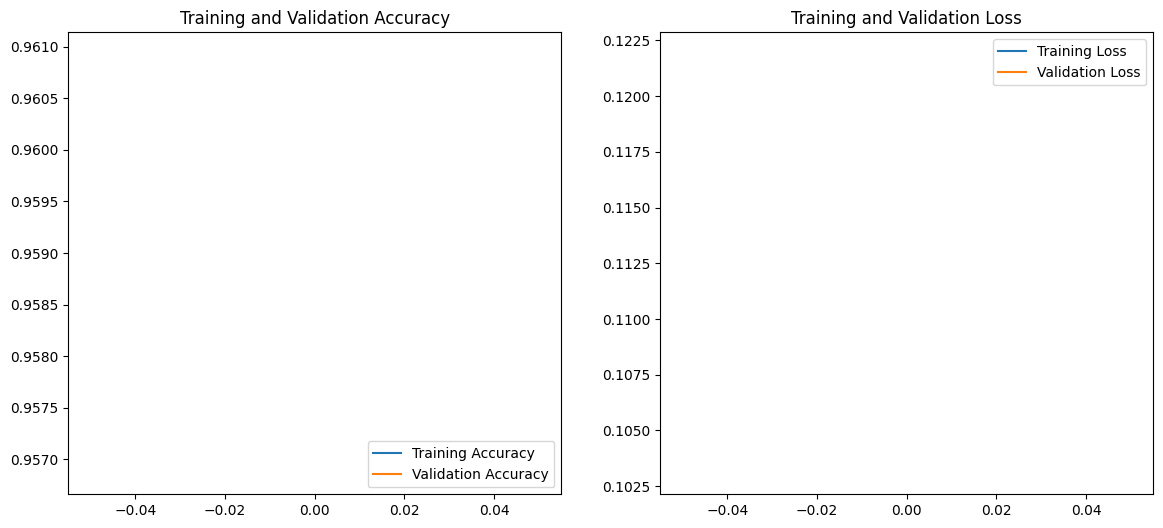

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9470 - loss: 0.1279
Test Accuracy: 95.31%


In [ ]:
y_pred = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


In [ ]:
y_pred_binary = np.where(y_pred > 0.65, 1, 0)

In [ ]:
l=[]
for i in np.arange(0.5,0.8,0.01):
  y_pred_binary = np.where(y_pred > i, 1, 0)
  a = accuracy_score(y_test, y_pred_binary)
  l.append(a)
  print(i,a)

0.5 0.953125
0.51 0.95
0.52 0.95
0.53 0.95
0.54 0.95
0.55 0.95
0.56 0.95
0.5700000000000001 0.95
0.5800000000000001 0.95
0.5900000000000001 0.95
0.6000000000000001 0.953125
0.6100000000000001 0.953125
0.6200000000000001 0.953125
0.6300000000000001 0.953125
0.6400000000000001 0.95625
0.6500000000000001 0.95625
0.6600000000000001 0.95625
0.6700000000000002 0.95625
0.6800000000000002 0.95625
0.6900000000000002 0.95625
0.7000000000000002 0.953125
0.7100000000000002 0.95625
0.7200000000000002 0.95625
0.7300000000000002 0.959375
0.7400000000000002 0.959375
0.7500000000000002 0.959375
0.7600000000000002 0.959375
0.7700000000000002 0.959375
0.7800000000000002 0.959375
0.7900000000000003 0.959375
0.8000000000000003 0.959375


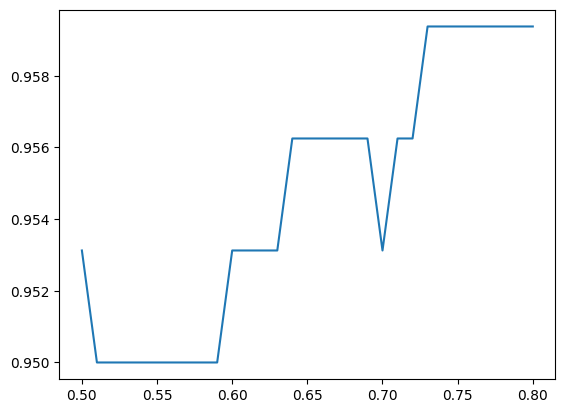

In [ ]:
plt.plot(np.arange(0.5,0.8,0.01),l)

In [ ]:
accuracy_score(y_test, y_pred_binary)

0.953125

In [ ]:
f1_score(y_test,y_pred_binary)

0.9529780564263323

In [ ]:
precision_score(y_test,y_pred_binary)

0.9559748427672956

In [ ]:
recall_score(y_test,y_pred_binary)

0.95

In [ ]:
confusion_matrix(y_test, y_pred_binary)

array([[154,   6],
       [  8, 152]])

<Axes: >

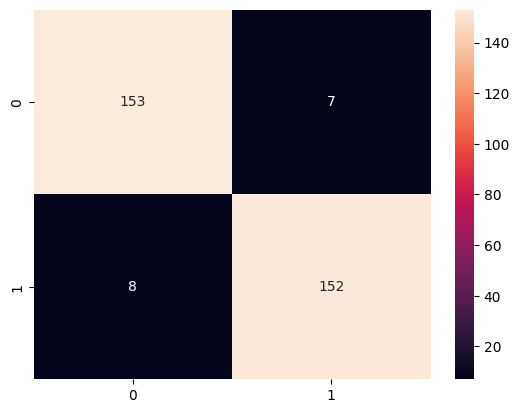

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_binary), annot=True, fmt='d')